In [7]:
%pylab inline
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable

from torchvision import transforms
from torchvision.datasets import MNIST

print(torch.__version__)
print("0.4.0" == torch.__version__)

Populating the interactive namespace from numpy and matplotlib
0.4.0
True


kwargs = {}

train = dataloader(
    MNIST(
        'data',
        train=True,
        download=True,
        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    ),
    batch_size=64,
    shuffle=True,
    **kwargs
)

In [8]:
train_data = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test_data = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

print("train_data:", train_data)
print("")
print("test_data:", test_data)

train_data: Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None

test_data: Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                         )
    Target Transforms (if any): None


In [3]:
# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=1, pin_memory=True)
train_loader = dataloader.DataLoader(train_data, **dataloader_args)
test_loader = dataloader.DataLoader(test_data, **dataloader_args)

print("train_data", train_data.train_data.cpu().numpy())

train_data [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [9]:

#train_data = train_data.train_data
transformed_train_data = train_data.transform(train_data.train_data.cpu().numpy())

print('[Train]')
print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_data.train_data.size())
print(' - Transformed Shape:', transformed_train_data.size())
print(' - min:', torch.min(transformed_train_data))
print(' - max:', torch.max(transformed_train_data))
print(' - mean:', torch.mean(transformed_train_data))
print(' - std:', torch.std(transformed_train_data))
print(' - var:', torch.var(transformed_train_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - Transformed Shape: torch.Size([28, 60000, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(1.00000e-02 *
       9.4930)


In [10]:
def createOptimizer(net):
    return optim.SGD(net.parameters(), lr=0.001, momentum=0.8)

#optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
def single_epoch_train(model, current_epoch, train_data_loader, optimizer):
    model.train()
    batch_losses = []
    #model.eval()

    for batch_id, (data, target) in enumerate(train_data_loader):
        #if torch.cuda.is_available():
        #if cuda #<= if gpu support, do something like
            #data = data.cuda()
            #target = target.cuda()
            
        #transform to variables
        data = Variable(data)
        target = Variable(target)
        
        #optimizer = createOptimizer(model) #<= not needed bec is passed
        optimizer.zero_grad()

        out = model(data) #out OR prediction
        #criterion = nn.CrossEntropyLoss
        criterion = F.nll_loss # criterion-fn
        loss = criterion(out, target)
        
        batch_losses.append(loss.data[0])

        loss.backward()
        
        optimizer.step()
        
        print('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                current_epoch, 
                batch_id * len(data), 
                len(train_data_loader.dataset),
                100. * batch_id / len(train_data_loader), 
                loss.data[0]
            ),
            end=''
        )
        
    return (model, batch_losses)

def train(net, train_data_loader, optimizer, count_epochs=15):
    #check count_epochs >= 1
    losses = []

    for current_epoch in range(1, count_epochs):
        (returnedNet, batch_losses) = single_epoch_train(net, current_epoch, train_data_loader, optimizer)
        net = returnedNet
        losses += batch_losses

    return (net, losses)

In [6]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        
        #add layers
        #input_features = 10
        conv1_inChannels = 1
        conv1_outChannels = 10
        conv1_kernalSize = 5
        self.conv1 = nn.Conv2d(conv1_inChannels, conv1_outChannels, conv1_kernalSize)
        
        conv2_inChannels = conv1_outChannels
        conv2_outChannels = 20
        conv2_kernalSize = 5
        self.conv2 = nn.Conv2d(conv2_inChannels, conv2_outChannels, conv2_kernalSize)
        
        self.conv_dropout = nn.Dropout2d
        
        self.fc1 = nn.Linear(320, 60) #fc1 = fully connected layer #320 = amount of pixels per image
        self.fc2 = nn.Linear(60, 10)
        
    def forward(self, x):
        #conv1
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)

        #conv2        
        x = self.conv2(x)
        #x = self.conv_dropout(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        
        #step to determine fc1 inputs??? = result leads to 320, but why, how to calc that???
        #print(x.size())
        #exit()
        
        #why???
        x = x.view(-1, 320)
        
        #fc1
        x = self.fc1(x)
        x = F.relu(x)
        
        #fc2 ~ output
        x = self.fc2(x)
        x = F.log_softmax(x)
        
        return x
        
    # helper function ??? why ???
    def num_flat_features(self, x):
        size = x.size()[1:] # attention: mini batch / stochachistig grad
        num = 1
        for i in size:
            num *= i
        return num

In [12]:
MyMNISTNet = MNISTNet()
#MyMNISTNet.cuda() #<= if cuda

MNISTOptimizer = createOptimizer(MyMNISTNet)

train(MyMNISTNet, train_loader, MNISTOptimizer, count_epochs=5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


 Train Epoch: 4 [29984/60000 (100%)]	Loss: 0.116158

(MNISTNet(
   (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
   (fc1): Linear(in_features=320, out_features=60, bias=True)
   (fc2): Linear(in_features=60, out_features=10, bias=True)
 ),
 [tensor(2.3202),
  tensor(2.2877),
  tensor(2.3063),
  tensor(2.3011),
  tensor(2.2990),
  tensor(2.3046),
  tensor(2.3190),
  tensor(2.3141),
  tensor(2.3026),
  tensor(2.3049),
  tensor(2.3107),
  tensor(2.3106),
  tensor(2.2917),
  tensor(2.3210),
  tensor(2.3120),
  tensor(2.2972),
  tensor(2.3063),
  tensor(2.3085),
  tensor(2.3057),
  tensor(2.3047),
  tensor(2.3037),
  tensor(2.3064),
  tensor(2.2997),
  tensor(2.3090),
  tensor(2.3128),
  tensor(2.2976),
  tensor(2.3139),
  tensor(2.2891),
  tensor(2.2804),
  tensor(2.2961),
  tensor(2.3036),
  tensor(2.3037),
  tensor(2.3105),
  tensor(2.3024),
  tensor(2.3020),
  tensor(2.3070),
  tensor(2.3018),
  tensor(2.3049),
  tensor(2.2979),
  tensor(2.2970),
  tensor(2.2957),
 

In [13]:
#evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
#evaluate_y = Variable(test_loader.dataset.test_labels)

evaluate_x = test_loader.dataset.test_data[0]
#evaluate_x = Variable(evaluate_x)

#evaluate_y = Variable(test_loader.dataset.test_labels[0])

#print(Variable(evaluate_x))
output = MyMNISTNet(evaluate_x)

print(output)

#pred = output.data.max(1)[1]
#d = pred.eq(evaluate_y.data).cpu()
#accuracy = d.sum()/d.size()[0]

#print('Accuracy:', accuracy)

RuntimeError: input has less dimensions than expected

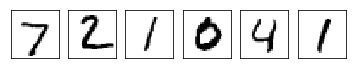

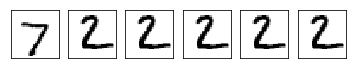

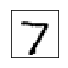

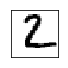

In [14]:
#print(test_loader.dataset.test_data)

import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

def plot_image(image):
    "Plot a MNIST image."
    fig = plt.figure()
    ax = fig.add_subplot(4, 1, 1)
    ax.matshow(image, cmap = matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()
    
plot_images_separately(test_loader.dataset.test_data)
plot_images_separately([
    test_loader.dataset.test_data[0],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1],
    test_loader.dataset.test_data[1]
])
plot_image(test_loader.dataset.test_data[0])
plot_image(test_loader.dataset.test_data[1])